<a href="https://colab.research.google.com/github/Malicious-traffic-in-IoT-networks/Machine-learning/blob/main/DDoS_Botnet_Attack_on_IOT_Devices_KNN.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## **01 데이터 업로드**

In [1]:
# 구글 드라이브 연결
from google.colab import drive
import numpy as np
drive.mount('/gdrive', force_remount=True)

Mounted at /gdrive


In [2]:
import pandas as pd

IoT_Botnet_Dataset = pd.read_csv('/gdrive/MyDrive/Taggle/IoT_Botnet_Dataset.csv')
IoT_Botnet_Dataset.head()

,pkSeqID,proto,saddr,sport,daddr,dport,seq,stddev,N_IN_Conn_P_SrcIP,min,state_number,mean,N_IN_Conn_P_DstIP,drate,srate,max,attack,category,subcategory
0,792371,udp,192.168.100.150,48516,192.168.100.3,80,175094,0.226784,100,4.100436,4,4.457383,100,0.000000,0.404711,4.719438,1,DoS,UDP
1,2056418,tcp,192.168.100.148,22267,192.168.100.3,80,143024,0.451998,100,3.439257,1,3.806172,100,0.225077,0.401397,4.442930,1,DDoS,TCP
2,2795650,udp,192.168.100.149,28629,192.168.100.3,80,167033,1.931553,73,0.000000,4,2.731204,100,0.000000,0.407287,4.138455,1,DDoS,UDP
3,2118009,tcp,192.168.100.148,42142,192.168.100.3,80,204615,0.428798,56,3.271411,1,3.626428,100,0.000000,0.343654,4.229700,1,DDoS,TCP
4,303688,tcp,192.168.100.149,1645,192.168.100.5,80,40058,2.058381,100,0.000000,3,1.188407,100,0.000000,0.135842,4.753628,1,DoS,TCP


## **2 Min-Max Normalization 정규화**
패킷 종류인 'category'를 target으로 하여 데이터셋 분류

In [3]:
from sklearn.model_selection import train_test_split

# 특성
data = IoT_Botnet_Dataset[[ 'seq', 'stddev', 'N_IN_Conn_P_SrcIP', 'min',
                            'state_number', 'mean', 'N_IN_Conn_P_DstIP', 'drate','srate', 'max']].to_numpy()
target = IoT_Botnet_Dataset['category']

# 데이터셋 분류 > 8:2
train_input, test_input, train_target, test_target = train_test_split(
data, target, test_size=0.2, random_state=42)

In [4]:
# 데이터셋 크기 확인
print("train_input 크기 : {}".format(train_input.shape))
print("train_target 크기 : {}".format(train_target.shape))
print("test_input 크기 : {}".format(test_input.shape))
print("test_target 크기 : {}".format(test_target.shape))

train_input 크기 : (586964, 10)
train_target 크기 : (586964,)
test_input 크기 : (146741, 10)
test_target 크기 : (146741,)


In [5]:
# MinMaxScaler 선언
from sklearn.preprocessing import MinMaxScaler
Scaler = MinMaxScaler()

# Input 데이터 스케일링
train_input_scale = Scaler.fit_transform(train_input)
test_input_scale = Scaler.fit_transform(test_input)

## **3 KNN**

1) n_neighbors의 수를 10으로 하여 학습 > 정확도 떨어짐

In [6]:
from sklearn.neighbors import KNeighborsClassifier

# KNeighborsClassifier 선언 및 학습
KNN = KNeighborsClassifier(n_neighbors=10)
KNN.fit(train_input_scale, train_target)

KNeighborsClassifier(n_neighbors=10)

In [7]:
# 모델평가
KNN.score(test_input_scale, test_target)

0.9881628174811402

In [8]:
# test/train input으로 테스트 진행
# 과대적합/과소적합 확인
print(KNN.score(train_input_scale, train_target))
print(KNN.score(test_input_scale, test_target))

0.9913009997205962
0.9881628174811402


2) cross_val_score을 사용해 최적의 KNN 파라미터 찾기

In [9]:
from sklearn.neighbors import  KNeighborsClassifier
from sklearn.model_selection import cross_val_score

# k의 범위를 3부터 10까지 홀수
max_k_range = 10 
k_list = []

for i in range(3, max_k_range, 2):
  k_list.append(i)

cross_validation_scores = []

#교차 검증(3-fold)을 각 k를 대상으로 수행해 검증 결과를 저장
for k in k_list:
  knn = KNeighborsClassifier(n_neighbors=k)
  scores = cross_val_score(knn, train_input_scale, train_target, cv=3,scoring='accuracy')
  cross_validation_scores.append(scores.mean())

cross_validation_scores

[0.9902140508818542, 0.9891390270653885, 0.9879634863738849, 0.986948092074599]

3) n_neighbors에 따른 정확도 시각화

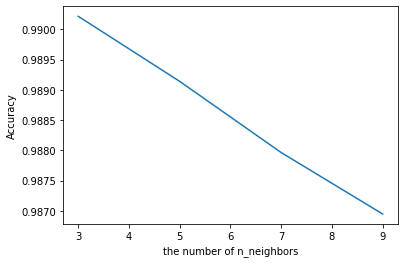

In [10]:
import matplotlib.pyplot as plt
plt.plot(k_list, cross_validation_scores)
plt.xlabel('the number of n_neighbors')
plt.ylabel('Accuracy')
plt.show()

4) n_neighbors의 수를 3으로 하여 학습 > 정확도 상승

In [11]:
# n_neignbors 변경 후 모델평가
KNN.n_neighbors = 3
KNN.fit(train_input_scale, train_target)
KNN.score(test_input_scale, test_target)

0.9907524141173905

In [12]:
# test/train input으로 테스트 진행
# 과대적합/과소적합 확인
print(KNN.score(train_input_scale, train_target))
print(KNN.score(test_input_scale, test_target))

0.9960713093136887
0.9907524141173905


## **4 DDoS Botnet Attack Dataset 예측**

In [13]:
import pandas as pd

DDos_Dataset = pd.read_csv('/gdrive/MyDrive/Taggle/DDoSdata.csv')
DDos_Dataset.head()

/usr/local/lib/python3.8/dist-packages/IPython/core/interactiveshell.py:3326: DtypeWarning: Columns (8,10) have mixed types.Specify dtype option on import or set low_memory=False.
  exec(code_obj, self.user_global_ns, self.user_ns)


,Unnamed: 0,pkSeqID,stime,flgs,flgs_number,proto,proto_number,saddr,sport,daddr,...,AR_P_Proto_P_DstIP,N_IN_Conn_P_DstIP,N_IN_Conn_P_SrcIP,AR_P_Proto_P_Sport,AR_P_Proto_P_Dport,Pkts_P_State_P_Protocol_P_DestIP,Pkts_P_State_P_Protocol_P_SrcIP,attack,category,subcategory
0,1650261,1650261,1.528103e+09,e,1,tcp,1,192.168.100.150,54110,192.168.100.3,...,1.21662,40,38,1.56093,1.21662,328,308,1,DDoS,HTTP
1,1650262,1650262,1.528103e+09,e,1,tcp,1,192.168.100.150,54112,192.168.100.3,...,1.21662,40,38,1.56107,1.21662,328,308,1,DDoS,HTTP
2,1650263,1650263,1.528103e+09,e,1,tcp,1,192.168.100.150,54114,192.168.100.3,...,1.21662,40,38,1.24980,1.21662,328,308,1,DDoS,HTTP
3,1650264,1650264,1.528103e+09,e,1,tcp,1,192.168.100.150,54116,192.168.100.3,...,1.21662,40,38,1.24986,1.21662,328,308,1,DDoS,HTTP
4,1650265,1650265,1.528103e+09,e,1,tcp,1,192.168.100.150,54118,192.168.100.3,...,1.21662,40,38,1.24991,1.21662,328,308,1,DDoS,HTTP


In [18]:
DDos_Dataset.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1927101 entries, 0 to 1927100
Data columns (total 47 columns):
 #   Column                            Dtype  
---  ------                            -----  
 0   Unnamed: 0                        int64  
 1   pkSeqID                           int64  
 2   stime                             float64
 3   flgs                              object 
 4   flgs_number                       int64  
 5   proto                             object 
 6   proto_number                      int64  
 7   saddr                             object 
 8   sport                             object 
 9   daddr                             object 
 10  dport                             object 
 11  pkts                              int64  
 12  bytes                             int64  
 13  state                             object 
 14  state_number                      int64  
 15  ltime                             float64
 16  seq                               in

In [19]:
# 특성
DDos_data = DDos_Dataset[[ 'seq', 'stddev', 'N_IN_Conn_P_SrcIP', 'min',
                            'state_number', 'mean', 'N_IN_Conn_P_DstIP', 'drate','srate', 'max']].to_numpy()
DDos_target = DDos_Dataset['category']

In [16]:
DDos_data = Scaler.fit_transform(DDos_data)

In [17]:
# 모델평가
KNN.score(DDos_data, DDos_target)

0.9380535841141694